In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from afv.finite_voronoi import PhysicalParams, FiniteVoronoiSimulator

In [2]:
def custom_plot_2d(pts: np.ndarray, diag: dict, r: float, lw=1., markersize=1., ax=None):
    """
    Custom plot function
    """
    if ax is None:
        ax = plt.gca()
    
    point_edges_type = diag["edges_type"]
    point_vertices_f_idx = diag["regions"]
    vertices_all = diag["vertices"]

    # Draw cell centers
    ax.plot(pts[:, 0], pts[:, 1], 'o', color='C1', markersize=markersize, zorder=3)

    N = len(pts)

    # Draw each cell boundary
    for idx in range(N):
        edges_type = point_edges_type[idx]
        vertices_f_idx = point_vertices_f_idx[idx]

        x, y = pts[idx]
        if len(edges_type) < 2:
            angle = np.linspace(0, 2*np.pi, 100)
            ax.plot(x + r * np.cos(angle), y + r * np.sin(angle), color="C4", lw=lw, zorder=1)
            # ax.fill(x + r * np.cos(angle), y + r * np.sin(angle), color="C3", alpha=0.2, zorder=0)
            continue

        for idx_f, edge_type in enumerate(edges_type):
            v1_idx = vertices_f_idx[idx_f]
            x1, y1 = vertices_all[v1_idx]
            idx2 = idx_f + 1 if idx_f < len(edges_type)-1 else 0
            v2_idx = vertices_f_idx[idx2]
            x2, y2 = vertices_all[v2_idx]

            if edge_type == 1:
                ax.plot([x1, x2], [y1, y2], color="C0", lw=lw, zorder=2)
                # ax.fill([x1, x2, x], [y1, y2, y], 'C3', alpha=0.2, zorder=0)
            else:
                angle1 = np.arctan2(y1-y, x1-x)
                angle2 = np.arctan2(y2-y, x2-x)
                dangle = np.linspace(0, (angle1 - angle2) % (2*np.pi), 100)

                ax.plot(x + r * np.cos(angle2+dangle), y + r * np.sin(angle2+dangle), color="C4", lw=lw, zorder=1)
                # ax.fill(np.append(x + r * np.cos(angle2+dangle), x), np.append(y + r * np.sin(angle2+dangle), y), color="C3", alpha=0.2, lw=0, zorder=0)

    ax.set_aspect("equal")
    return ax

In [3]:
radius = 1.0    # maximal radius

# Parameter set
phys = PhysicalParams(
        r=radius,
        A0=np.pi,
        P0=4.8,
        KA=1.0,
        KP=1.0,
        lambda_tension=0.2,
    )

In [4]:
np.random.seed(42)

N = 100         # number of cells
Lx = 1          # box size
Ly = 0.618      # box size

x = np.random.uniform(0, Lx, size=N)
y = np.random.uniform(0, Ly, size=N)
pts = np.column_stack((x, y))
pts *= 25

# Initialize simulator
sim = FiniteVoronoiSimulator(pts, phys)

In [5]:
dt = 0.01        # time step

for _ in tqdm(range(1000), desc="Relaxation"):
    diag = sim.build()
    pts += diag['forces'] * dt
    sim.update_positions(pts)

Relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

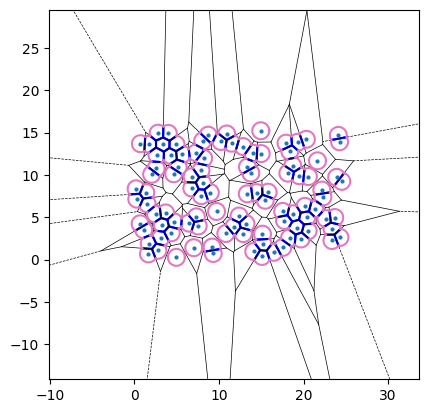

In [6]:
# Default plotting routine
fig, ax = plt.subplots(dpi=100)
sim.plot_2d(ax=ax)
plt.show()

In [7]:
# Get all information directly

(vor, vertices_all, ridge_vertices_all, num_vertices,
            vertexpair2ridge, vertex_points) = sim._build_voronoi_with_extensions()

geom, vertices_all = sim._per_cell_geometry(vor, vertices_all, ridge_vertices_all, num_vertices, vertexpair2ridge)

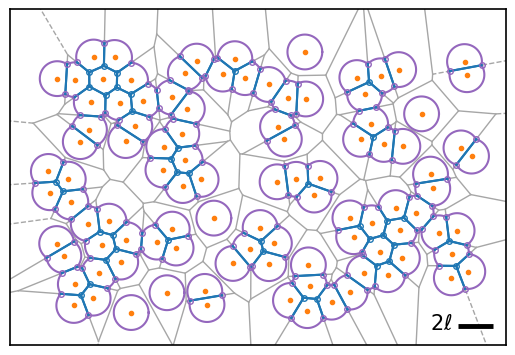

In [9]:
fig, ax = plt.subplots(dpi=100)

box_size = 12
center = np.mean(pts, axis=0)

gray_color = 0.65 * np.ones(3)
# Draw Voronoi ridge segments
for idx in range(len(vor.ridge_vertices)):
    x1, y1 = vertices_all[ridge_vertices_all[idx][0]]
    x2, y2 = vertices_all[ridge_vertices_all[idx][1]]
    if -1 not in vor.ridge_vertices[idx]:
        ax.plot([x1, x2], [y1, y2], '-', lw=1, color=gray_color, zorder=-1)
    else:
        ax.plot([x1, x2], [y1, y2], '--', lw=1, color=gray_color, zorder=-1)

# Draw all vertices
vertices_in = vertices_all[list(geom['vertex_in_id'])]
ax.plot(vertices_in[:, 0], vertices_in[:, 1], 'o', color='C0', markersize=4, markerfacecolor='None', zorder=3)
vertices_out = vertices_all[list(geom['vertex_out_id'])]
ax.plot(vertices_out[:, 0], vertices_out[:, 1], 'o', color='C4', markersize=4, markerfacecolor='None', zorder=3)

custom_plot_2d(pts, diag, r=radius, lw=1.5, markersize=3)
ax.tick_params(axis='both', length=0, labelbottom=False, labelleft=False)

bar_left = center[0]+box_size+1.
bar_y = center[1]-box_size+3.8
ax.plot([bar_left-radius, bar_left+radius], [bar_y, bar_y], 'k-', lw=3.5, solid_capstyle='butt')   # <-- no rounded extension
ax.text(bar_left-1.1-1.5, bar_y-0.2, r'$2\ell$', fontsize=15)  # cell diameter as scale bar

for spine in ax.spines.values():
    spine.set_linewidth(1.2)   # choose your thickness

ax.set_xlim(center[0]-box_size-1.75, center[0]+box_size+2.75)
ax.set_ylim(center[1]-box_size+2.7, center[1]+box_size-2)
# plt.savefig('model_illustration.png', dpi=300, bbox_inches='tight')

plt.show()